Dataset Loaded Successfully
Shape: (20640, 10)

Missing Values:


,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,207
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0



Data Types:


,0
longitude,float64
latitude,float64
housing_median_age,int64
total_rooms,int64
total_bedrooms,float64
population,int64
households,int64
median_income,float64
median_house_value,int64
ocean_proximity,object


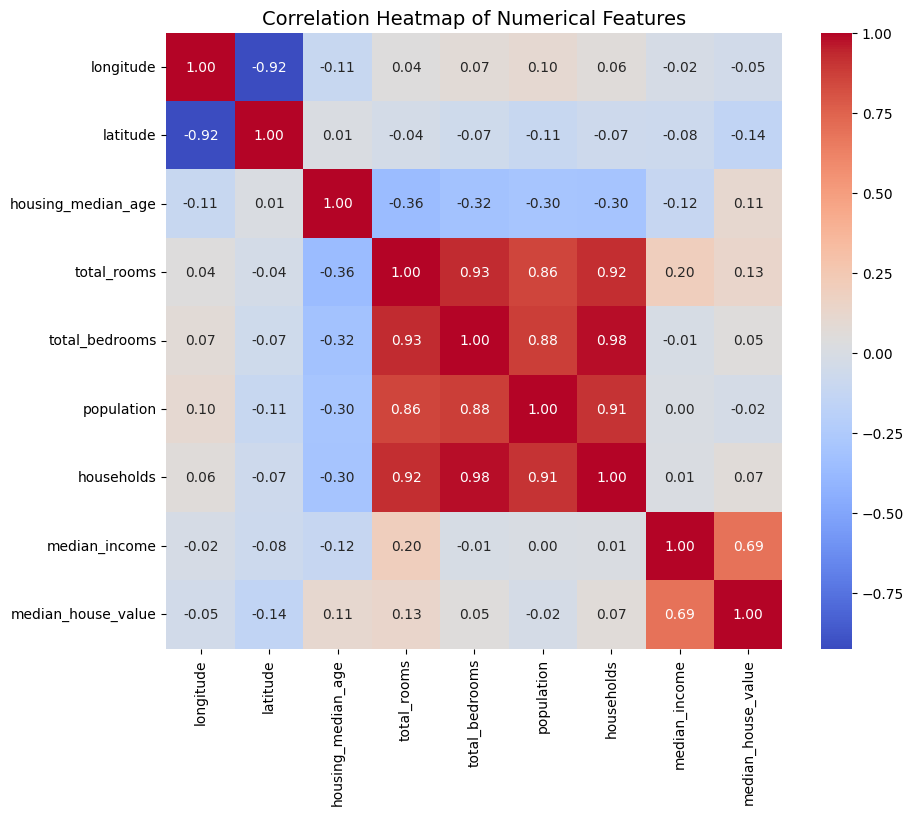


Training model... (please wait)
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Model Training Complete!
Best Parameters: {'regressor__max_depth': None, 'regressor__max_features': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 234}

Model Evaluation:
RMSE: 49124.58
R² Score: 0.82


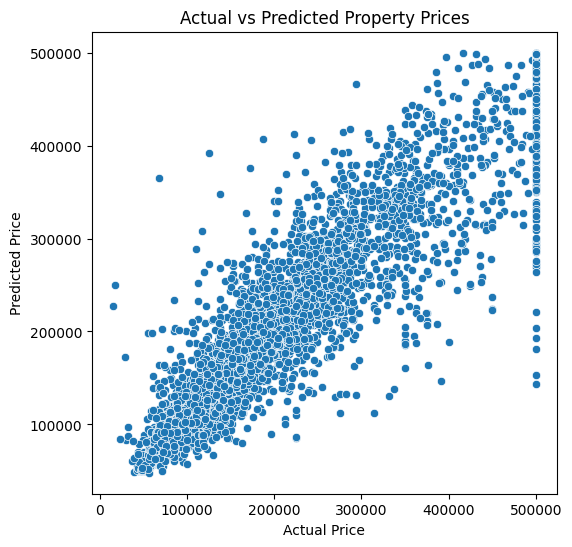

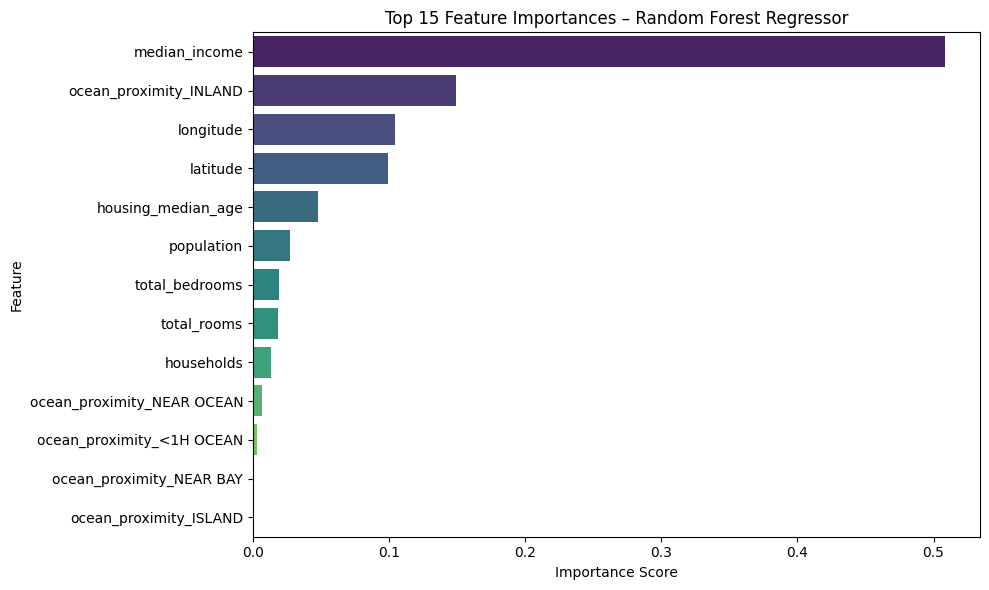


Training and Validation Performance Summary:
Average Cross-Validation R² Score: 0.816 ± 0.004
Average Cross-Validation RMSE: 49620.67 ± 670.39
Test Set R² Score: 0.816
Test Set RMSE: 49124.58


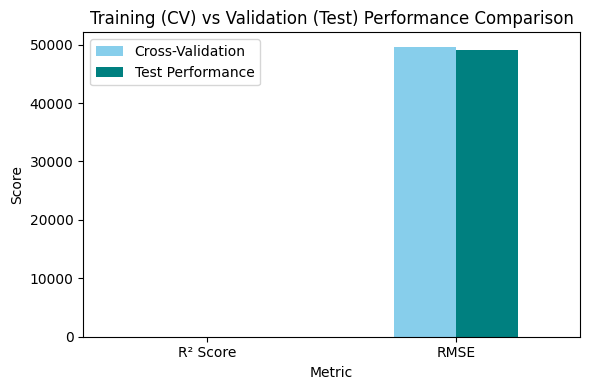


Model saved as 'property_price_model.pkl'
How many Properties Price you want to predict? 1

Enter property details for price prediction:

Enter longitude: -122
Enter latitude: 37
Enter housing median age: 10
Enter total rooms: 100
Enter total bedrooms: 200
Enter population: 400
Enter number of households: 100
Enter median income: 8
Enter ocean proximity (e.g., NEAR OCEAN, INLAND, ISLAND): ISLAND

Predicted Median House Value: $408,247.27


In [ ]:
# --- 1. Importing Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from scipy.stats import randint
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings("ignore")

# --- 2. Load Dataset ---
df = pd.read_excel("drive/MyDrive/Data_file.xlsx")

print("Dataset Loaded Successfully")
print("Shape:", df.shape)

# --- 3. Basic Data Understanding ---
print("\nMissing Values:")
display(df.isnull().sum())

print("\nData Types:")
display(df.dtypes)

# --- 4. Exploratory Data Analysis (EDA) ---
# Correlation Heatmap (for numerical features only)
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap of Numerical Features", fontsize=14)
plt.show()

# --- 5. Data Preprocessing ---
target_column = 'median_house_value'
X = df.drop(columns=[target_column])
y = df[target_column]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify column types
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# --- 6. Transformers ---
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# --- 7. Model Building ---
rf = RandomForestRegressor(random_state=42)

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', rf)
])

# --- 8. Hyperparameter Tuning (RandomizedSearchCV) ---
param_dist = {
    'regressor__n_estimators': randint(100, 300),
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=2,
    verbose=2,
    random_state=42,
    error_score='raise'
)

print("\nTraining model... (please wait)")
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

print("\nModel Training Complete!")
print("Best Parameters:", random_search.best_params_)

# --- 9. Model Evaluation ---
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nModel Evaluation:")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# --- 10. Visualization ---

# (a) Scatter Plot of Actual vs Predicted
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=1)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Property Prices")
plt.show()

# (b) Feature Importance Visualization
rf_model = best_model.named_steps['regressor']
encoded_cat_features = best_model.named_steps['preprocessor']\
    .named_transformers_['cat']\
    .named_steps['onehot']\
    .get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([numeric_cols, encoded_cat_features])
feature_importances = rf_model.feature_importances_

feat_imp_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title("Top 15 Feature Importances – Random Forest Regressor")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# --- 11. Training and Validation Performance Summary ---
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')
cv_rmse_scores = np.sqrt(-cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))

print("\nTraining and Validation Performance Summary:")
print(f"Average Cross-Validation R² Score: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
print(f"Average Cross-Validation RMSE: {cv_rmse_scores.mean():.2f} ± {cv_rmse_scores.std():.2f}")
print(f"Test Set R² Score: {r2:.3f}")
print(f"Test Set RMSE: {rmse:.2f}")

# Visual comparison of CV vs Test performance
performance_data = {
    'Metric': ['R² Score', 'RMSE'],
    'Cross-Validation': [cv_scores.mean(), cv_rmse_scores.mean()],
    'Test Performance': [r2, rmse]
}
performance_df = pd.DataFrame(performance_data)

performance_df.plot(
    x='Metric', kind='bar', figsize=(6,4),
    title='Training (CV) vs Validation (Test) Performance Comparison',
    ylabel='Score', color=['skyblue', 'teal']
)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# --- 12. Save Model ---
joblib.dump(best_model, 'drive/MyDrive/property_price_model.pkl')
print("\nModel saved as 'property_price_model.pkl'")

# --- 13. USER INPUT SECTION ---
def get_user_input():
    print("\nEnter property details for price prediction:\n")
    user_data = {
        'longitude': float(input("Enter longitude: ")),
        'latitude': float(input("Enter latitude: ")),
        'housing_median_age': float(input("Enter housing median age: ")),
        'total_rooms': float(input("Enter total rooms: ")),
        'total_bedrooms': float(input("Enter total bedrooms: ")),
        'population': float(input("Enter population: ")),
        'households': float(input("Enter number of households: ")),
        'median_income': float(input("Enter median income: ")),
        'ocean_proximity': input("Enter ocean proximity (e.g., NEAR OCEAN, INLAND, ISLAND): ")
    }
    return pd.DataFrame([user_data])

print("How many Properties Price you want to predict?", end=" ")
num_properties = int(input())
for _ in range(num_properties):
    user_df = get_user_input()
    predicted_price = best_model.predict(user_df)
    print(f"\nPredicted Median House Value: ${predicted_price[0]:,.2f}")


In [ ]:
# --- Import Required Libraries ---
import pandas as pd
import joblib

# --- Load the Saved Model ---
# Make sure 'property_price_model.pkl' exists in your working directory
model = joblib.load('drive/MyDrive/property_price_model.pkl')
print("✅ Model loaded successfully! Ready for predictions.")

# --- Function for User Input ---
def get_user_input():
    print("\nEnter property details for price prediction:\n")
    user_data = {
        'longitude': float(input("Enter longitude: ")),
        'latitude': float(input("Enter latitude: ")),
        'housing_median_age': float(input("Enter housing median age: ")),
        'total_rooms': float(input("Enter total rooms: ")),
        'total_bedrooms': float(input("Enter total bedrooms: ")),
        'population': float(input("Enter population: ")),
        'households': float(input("Enter number of households: ")),
        'median_income': float(input("Enter median income: ")),
        'ocean_proximity': input("Enter ocean proximity (e.g., NEAR OCEAN, INLAND, ISLAND): ")
    }
    return pd.DataFrame([user_data])

# --- Make Predictions Using the Loaded Model ---
print("How many Properties Price you want to predict?", end=" ")
num_properties = int(input())

for _ in range(num_properties):
    user_df = get_user_input()
    predicted_price = model.predict(user_df)
    print(f"\n🏡 Predicted Median House Value: ${predicted_price[0]:,.2f}")

✅ Model loaded successfully! Ready for predictions.
How many Properties Price you want to predict? 
Enter property details for price prediction:

